# Basic Probability Calculations

In [1]:
import scipy.stats as stats 
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.interpolate import interp1d

In [3]:
# define a function that would give you a 2D distribution. Do not pick a Gaussian.

"""def f(x,y):
    return np.exp(-(x**2+y**2)/25)*np.sin(x-1)**2*np.cos((y+0.5)/2)**2"""

def f(x,y):
    return stats.skewnorm.pdf(x, 3, loc=2, scale=3)*stats.skewnorm.pdf(y, -2, loc=5, scale=2)

# define a prior box:
x_array = np.arange(-5,10,0.01)
y_array = np.arange(-5,10,0.01)
xs,ys = np.meshgrid(x_array, y_array, indexing='ij')

#plt.scatter(xs, ys,s=0.01)

print(x_array.shape)
print(y_array.shape)
print(xs.shape)
print(ys.shape)

(1500,)
(1500,)
(1500, 1500)
(1500, 1500)


In [4]:
# sample your reference probability on a 2D regular grid in the prior box

f_sampled = f(xs,ys)


In [5]:
print(xs.shape)
print(f_sampled.shape)
print(ys.shape)

(1500, 1500)
(1500, 1500)
(1500, 1500)


In [6]:
# normalize the pdf

int_x = np.trapz(f_sampled, x_array, axis=0)
print(int_x.shape)
int = np.trapz(int_x, y_array)
print(int.shape)
print(int)

(1500,)
()
0.9922623006936371


In [7]:
pdf = f_sampled/int

new_int = np.trapz(np.trapz(pdf, x_array, axis=0), y_array)
print(new_int)
print(xs.shape)
print(ys.shape)
print(pdf.shape)

1.0000000000000002
(1500, 1500)
(1500, 1500)
(1500, 1500)


Text(0.5, 1.0, 'contours')

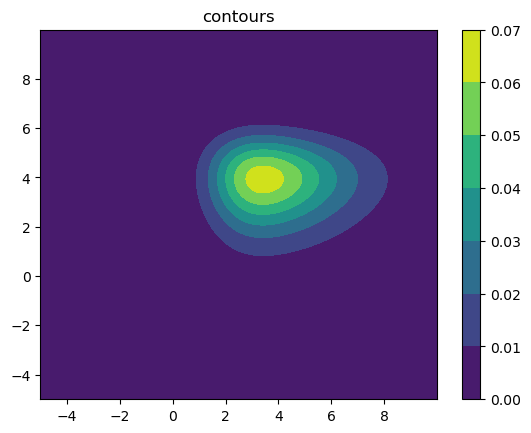

In [8]:
# contour plot the distribution (on generic iso-contours, the default ones work)
contour=plt.contourf(xs,ys, pdf)
#plt.clabel(contour, inline=False, fontsize=8)
plt.colorbar(contour)
plt.title('contours')



In [9]:
# marginalize the distribution and get two 1D distributions. Plot them.

pdf_of_y = np.trapz(pdf, xs, axis=0)
pdf_of_x = np.trapz(pdf, ys, axis=1)

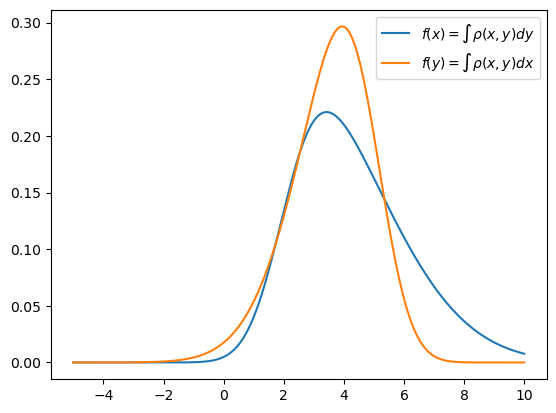

In [10]:
plt.plot(x_array, pdf_of_x, label=r'$f(x)=\int \rho(x,y)dy$')
plt.plot(y_array, pdf_of_y, label=r'$f(y)=\int \rho(x,y)dx$')
plt.legend()

In [11]:
# check that marginalization does not alter the normalization of the pdf.

norm_f_x = np.trapz(pdf_of_x, x_array)
print(norm_f_x)
norm_f_y = np.trapz(pdf_of_y, y_array)
print(norm_f_x)

1.0
1.0


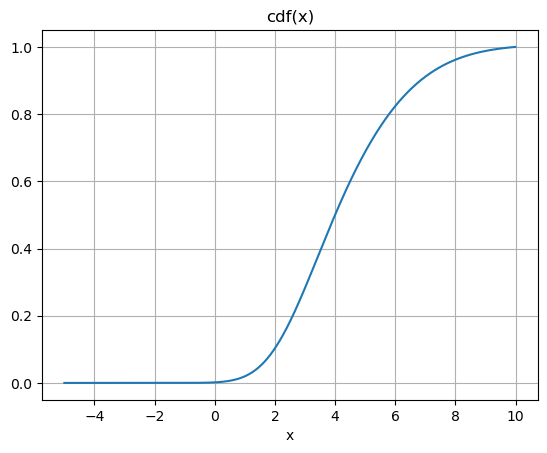

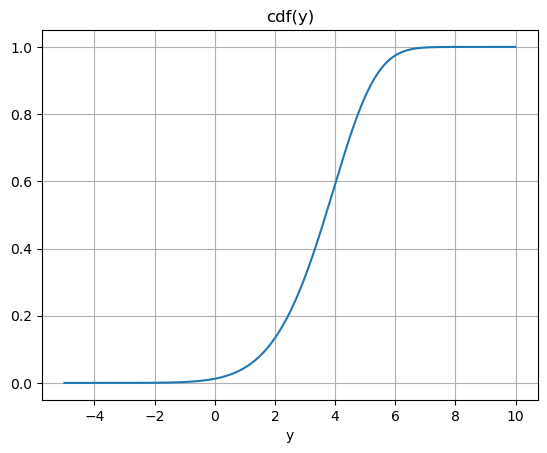

In [12]:
# calculate the cumulative distribution function of the 1D distribution. Plot it.

cdf_x = np.array([np.trapz(pdf_of_x[:i], x_array[:i]) for i in range(1, len(x_array) + 1)])
plt.plot(x_array, cdf_x)
plt.title('cdf(x)')
plt.xlabel('x')
plt.grid()
plt.show()

cdf_y = [np.trapz(pdf_of_y[:i], y_array[:i]) for i in range(1, len(y_array) + 1)]
plt.plot(y_array, cdf_y)
plt.title('cdf(y)')
plt.xlabel('y')
plt.grid()
plt.show()

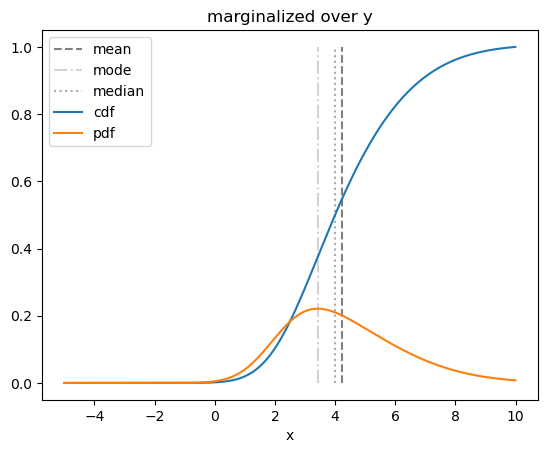

In [13]:
# calculate the mean, median and mode. Add them to the plot.

mean_x = np.trapz(x_array*pdf_of_x, x_array)
mode_x = x_array[np.argmax(pdf_of_x)]
inverse_cdf = interp1d(cdf_x, x_array)
median_x = inverse_cdf(0.5)

plt.vlines(mean_x, 0.0,1, label='mean', linestyles='--', color='grey')
plt.vlines(mode_x, 0.0, 1, label = 'mode', linestyles='-.', color='lightgrey')
plt.vlines(median_x, 0.0, 1, label = 'median', linestyles=':', color='darkgrey')

plt.plot(x_array, cdf_x, label='cdf')
plt.plot(x_array, pdf_of_x, label='pdf')
plt.title('marginalized over y')
plt.xlabel('x')
plt.legend()
plt.show()


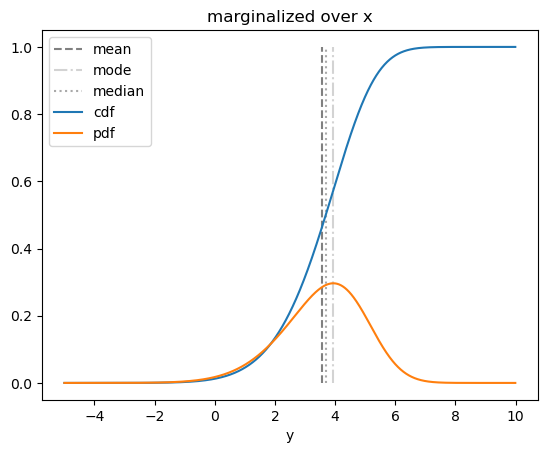

In [14]:
mean_y = np.trapz(y_array*pdf_of_y, y_array)
mode_y = y_array[np.argmax(pdf_of_y)]
inverse_cdf = interp1d(cdf_y, y_array)
median_y = inverse_cdf(0.5)

plt.vlines(mean_y, 0.0,1.0, label='mean', linestyles='--', color='grey')
plt.vlines(mode_y, 0.0, 1.0, label = 'mode', linestyles='-.', color='lightgrey')
plt.vlines(median_y, 0.0, 1.0, label = 'median', linestyles=':', color='darkgrey')

plt.plot(y_array, cdf_y, label='cdf')
plt.plot(y_array, pdf_of_y, label='pdf')
plt.title('marginalized over x')
plt.xlabel('y')
plt.legend()
plt.show()


()
(1500,)
<class 'numpy.ndarray'>


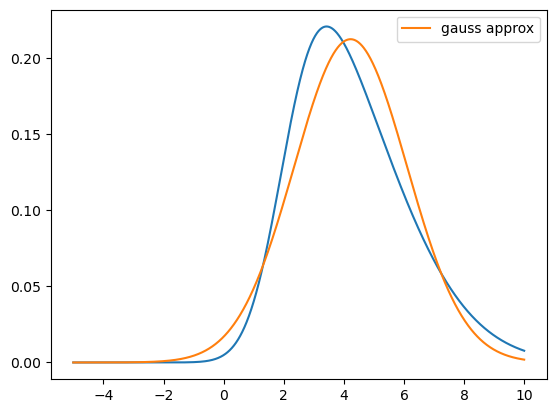

In [15]:
# calculate the variance of the 1D distribution. Add to the plot the Gaussian approximation of your distribution.


var_x = np.trapz((x_array-mean_x)**2*pdf_of_x, x_array)
print(var_x.shape)
print(pdf_of_x.shape)
pdf_x_gauss_approx = stats.norm(loc=mean_x, scale=(var_x**0.5)).pdf(x_array)
print(type(pdf_x_gauss_approx))

plt.plot(x_array, pdf_of_x)
plt.plot(x_array, pdf_x_gauss_approx, label='gauss approx')
plt.legend()

In [16]:
# calculate and plot the 68% HPD region for the 1D distribution. Plot it

## note: this only works if the distribution is mono-modal
## it gets nasty otherwise

def hpd(x, density, coverage):
    best = 0
    ai_best = 0
    bi_best = 0
    
    for ai in range(len(x) - 1):                                            ## vary min of the interval
        for bi in range(ai + 1, len(x)):                                    ## vary max of the interval
            interval_width = x[bi] - x[ai]
            #mass = sum((density[ai + 1 : bi]) * np.diff(x[ai : bi]))        ## integral on the interval
            mass = np.trapz(density[ai : bi], x[ai : bi])
            if mass >= coverage and mass / interval_width > best:           
                best = mass / interval_width
                ai_best = ai
                bi_best = bi
    
    return ai_best, bi_best                                                 ## returns the indexes


In [17]:
## on my nasty pdf
i_min, i_max = hpd(x_array, pdf_of_x, 0.68)
print(i_min, i_max)
print(np.trapz(pdf_of_x[i_min:i_max], x_array[i_min:i_max]))
p_tilde=pdf_of_x[i_min]

print(p_tilde)
print(pdf_of_x[i_max])

696 1063
0.6805254883610907
0.12973005521767889
0.1288858505927321


In [18]:
## check of the integral

np.trapz(pdf_of_x[i_min:i_max],x_array[i_min:i_max])

0.6805254883610907

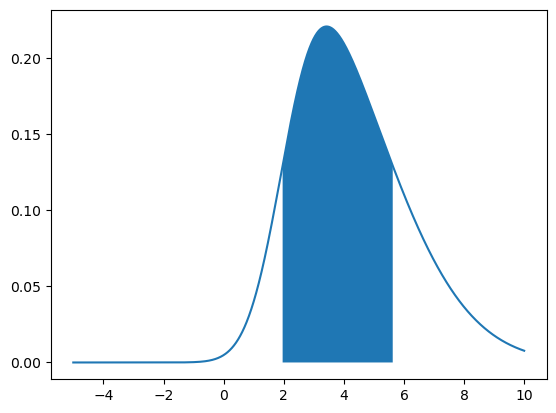

In [19]:
plt.plot(x_array, pdf_of_x)
plt.fill_between(x_array[i_min:i_max], pdf_of_x[i_min:i_max])

In [20]:
# make a 2D contour plot of the 2D 68% HPD region. How does it relate to the 1D region?

